In [22]:
import numpy as np
#from plotly.offline import iplot
#import plotly.graph_objs as go
import torch
from torch import nn
import matplotlib.pyplot as plt

# vector graphics plots within the notebook
%config InlineBackend.figure_format = 'svg'


torch.manual_seed(42)

In [2]:
class BVP:
    def __init__(self, alphas, ns, g_func, domain_ends, bcs):
        """
        Initializes a boundary value problem for a second-order ODE.
        
        Args:
            alphas (tuple): A 3-tuple of coefficients (alpha0, alpha1, alpha2) for the ODE terms.
            ns (tuple): A 3-tuple of powers (n0, n1, n2) for the ODE terms.
            g_func (callable): The right-hand side function g(x).
            domain_ends (tuple): The domain ends (a, b).
            bcs (tuple): The Dirichlet boundary conditions y(a) and y(b).
        """
        # Unpack the tuples
        self.alpha0, self.alpha1, self.alpha2 = alphas
        self.n0, self.n1, self.n2 = ns
        
        self.g_func = g_func
        self.domain_ends = domain_ends
        self.bcs = bcs

    def eval_ode(self, x, y, y_prime, y_double_prime):
        """
        Evaluates the left-hand side of the ODE given y, y', and y''.
        Given a valid solution, THIS SHOULD EQUAL ZERO
        """
        term2 = self.alpha2 * (y_double_prime ** self.n2)
        term1 = self.alpha1 * (y_prime ** self.n1)
        term0 = self.alpha0 * (y ** self.n0)
        return term2 + term1 + term0 - self.g_func(x)

In [3]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=5, depth=1):
        """
        Initializes all required hyperparameters for a typical model and dynamically
        creates layers based on the depth of the network.

        Args:
            input_features (int): Number of input features to the model.
            output_features (int): Number of output features of the model (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 5.
            depth (int): Determines the depth of the network, default 3.
        """
        super().__init__()
        
        layers = [nn.Linear(in_features=input_features, out_features=hidden_units), nn.Sigmoid()]
        
        # Add hidden layers based on the depth parameter
        for _ in range(depth - 1):
            layers.append(nn.Linear(in_features=hidden_units, out_features=hidden_units))
            layers.append(nn.SiLU())
        
        # Add the final layer
        layers.append(nn.Linear(in_features=hidden_units, out_features=output_features))
        
        # Create the sequential model
        self.stack = nn.Sequential(*layers)

    def forward(self, x):
        return self.stack(x)

In [4]:
class CustomLoss(nn.Module):
    def __init__(self, bvp, gamma=1):
        super().__init__()
        self.bvp = bvp
        self.gamma = gamma

    def forward(self, x, y):
        y_x = torch.autograd.grad(y, x, torch.ones_like(y), create_graph=True)[0]
        y_xx = torch.autograd.grad(y_x, x, torch.ones_like(y_x), create_graph=True)[0]
        ode_loss = torch.mean(self.bvp.eval_ode(x, y, y_x, y_xx) ** 2)
        bc_loss = self.gamma * ((y[0] - self.bvp.bcs[0]) ** 2 + (y[-1] - self.bvp.bcs[1]) ** 2)
        return ode_loss + bc_loss

In [5]:
def train_model(model, optimiser, bvp, x_train, no_epochs):
    loss_values = []  # List to store loss values
    loss_class = CustomLoss(bvp)
    
    for epoch in range(no_epochs):
        model.train()
        y_pred = model(x_train)
        y_pred.requires_grad_(True)
        loss = loss_class(x_train, y_pred)
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        # Store the loss value for this epoch
        loss_values.append(loss.item())

        if epoch % 100 == 0:
            print(f"Epoch: {epoch} | Loss: {loss.item():e}")
    
    return loss_values  # Return the list of loss values

In [6]:
def plot_loss_vs_epoch(loss_values):
    plt.figure(figsize=(10, 6))
    plt.plot(loss_values, label='Training Loss', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epoch')
    plt.yscale('log')  # Set the y-axis to logarithmic scale
    plt.legend()
    plt.show()

In [18]:
def plot_predictions_vs_analytical(model, x_train_tensor, exact_solution_func):
    # Convert the training tensor to numpy for plotting
    x_train_numpy = x_train_tensor.detach().numpy().flatten()
    
    # Predictions from the neural network
    with torch.no_grad():  # We do not need gradients for plotting
        y_pred_tensor = model(x_train_tensor)
    y_pred_numpy = y_pred_tensor.detach().numpy().flatten()
    
    # Analytical solution
    y_exact_numpy = exact_solution_func(x_train_numpy)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(x_train_numpy, y_pred_numpy, label='NN Predictions', color='r', linestyle='-.')
    plt.plot(x_train_numpy, y_exact_numpy, label='Analytical Solution', color='b', linestyle='-')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Neural Network Predictions vs. Analytical Solution')
    plt.legend()
    plt.show()

In [8]:
def plot_predictions_only(model, x_train_tensor):
    # Convert the training tensor to numpy for plotting
    x_train_numpy = x_train_tensor.detach().numpy().flatten()
    
    # Predictions from the neural network
    with torch.no_grad():  # We do not need gradients for plotting
        y_pred_tensor = model(x_train_tensor)
    y_pred_numpy = y_pred_tensor.detach().numpy().flatten()
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(x_train_numpy, y_pred_numpy, label='NN Predictions', color='r', linestyle='-.')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Neural Network Predictions')
    plt.legend()
    plt.show()

In [48]:
def plot_ode_residuals(model, bvp, x_train_tensor):
    # Ensure no gradients are computed in this analysis
    # Convert the training tensor to numpy for x-axis plotting
    x_train_numpy = x_train_tensor.detach().numpy().flatten()
    
    # Predictions from the neural network
    y_pred = model(x_train_tensor)
    y_pred_numpy = y_pred.detach().numpy().flatten()

    # Compute derivatives
    y_pred.requires_grad_(True)
    y_x = torch.autograd.grad(y_pred, x_train_tensor, torch.ones_like(y_pred), create_graph=True)[0]
    y_xx = torch.autograd.grad(y_x, x_train_tensor, torch.ones_like(y_x), create_graph=True)[0]
    
    # Evaluate the ODE residuals
    residuals = bvp.eval_ode(x_train_tensor, y_pred, y_x, y_xx).detach().numpy().flatten()
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(x_train_numpy, residuals, label='ODE Residuals', color='blue', linestyle='-.')
    plt.axhline(0, color='black', lw=1)  # Zero line for reference
    plt.xlabel('x')
    plt.ylabel('Residual')
    plt.yscale('log')
    plt.title('ODE Residuals Across the Domain')
    plt.legend()
    plt.show()

In [52]:
"""

ENTERING RELEVANT PARAMETERS

"""

# PROPOSED BOUNDARY VALUE PROBLEM
# ODE: -y'' + y^2 = g(x)
# g(x) = 3 + 2 * x - x ** 2 - 2 * x ** 3 + x ** 4
# y(0) = y(1) = 1
# use this input code for the proposed problem:

g_func=lambda x: 3 + 2 * x - x**2 - 2 * x**3 + x**4
alphas = (1, 2, -1)
ns = (2, 3, 1)
domain_ends = (0, 1)
bcs = (1, 1)


"""
alphas = (64, 0, 1)
ns = (1, 1, 1)
domain_ends = (0, (6 * np.pi + np.pi / 2) / 8)
bcs = (1, 0) # DIRICHLET
def g_func(x): return 0 # RHS function (inhomogeneity)
"""

# MODEL
ANN_width = 20
ANN_depth = 5


# TRAINING
no_epochs = 10000
learning_rate = 0.007


training_points = np.linspace(domain_ends[0], domain_ends[1], 100)
x_train = torch.tensor(training_points).resize_(len(training_points), 1)
x_train = x_train.to(torch.float32).requires_grad_(True)


# DEFINE BVP INSTANCE
# ODE: alpha0 * y^(n0) + alpha1 * (y')^(n1) + alpha2 * (y'')^(n2)
my_bvp = BVP(
    alphas=alphas,  # Corresponds to alpha0, alpha1, alpha2
    ns=ns,  # Corresponds to n0, n1, n2
    g_func=g_func,
    domain_ends=domain_ends,
    bcs=bcs
)


# LOSS CLASS
loss_class = CustomLoss(bvp=my_bvp, gamma=1.5)

#def exact_sol(x): return np.cos(8 * x)

In [61]:
# TRAIN THE MODEL, RESET IT EACH TIME
model = NeuralNetwork(1, 1, ANN_width, ANN_depth)

optimiser = torch.optim.Adam(params=model.parameters())
loss_values = train_model(model, optimiser, my_bvp, x_train, no_epochs)

Epoch: 0 | Loss: 1.319689e+01
Epoch: 100 | Loss: 1.233847e+00
Epoch: 200 | Loss: 1.217449e+00
Epoch: 300 | Loss: 1.155218e+00
Epoch: 400 | Loss: 8.044004e-01
Epoch: 500 | Loss: 1.075797e-01
Epoch: 600 | Loss: 6.672841e-02
Epoch: 700 | Loss: 6.129207e-02
Epoch: 800 | Loss: 5.801213e-02
Epoch: 900 | Loss: 5.599125e-02
Epoch: 1000 | Loss: 5.468059e-02
Epoch: 1100 | Loss: 5.371265e-02
Epoch: 1200 | Loss: 5.280733e-02
Epoch: 1300 | Loss: 5.167848e-02
Epoch: 1400 | Loss: 4.984137e-02
Epoch: 1500 | Loss: 4.591534e-02
Epoch: 1600 | Loss: 3.376204e-02
Epoch: 1700 | Loss: 5.349165e-03
Epoch: 1800 | Loss: 3.770343e-03
Epoch: 1900 | Loss: 3.334552e-03
Epoch: 2000 | Loss: 3.026636e-03
Epoch: 2100 | Loss: 2.790866e-03
Epoch: 2200 | Loss: 2.593336e-03
Epoch: 2300 | Loss: 2.413677e-03
Epoch: 2400 | Loss: 2.239761e-03
Epoch: 2500 | Loss: 2.064454e-03
Epoch: 2600 | Loss: 1.883485e-03
Epoch: 2700 | Loss: 1.694500e-03
Epoch: 2800 | Loss: 1.496559e-03
Epoch: 2900 | Loss: 1.290073e-03
Epoch: 3000 | Loss: 1.

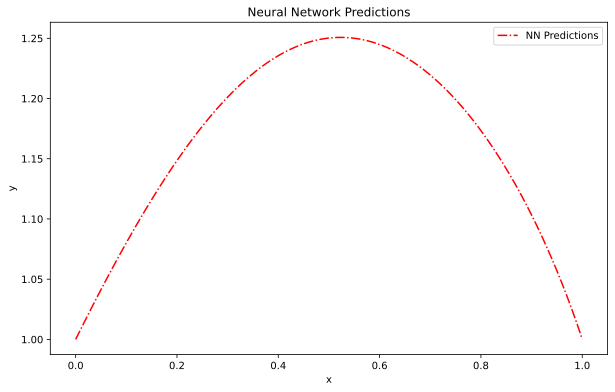

In [62]:
# IF NO ANALYTICAL SOLN AVAILABLE
#plot_predictions_vs_analytical(model, x_train, exact_sol)
plot_predictions_only(model, x_train)

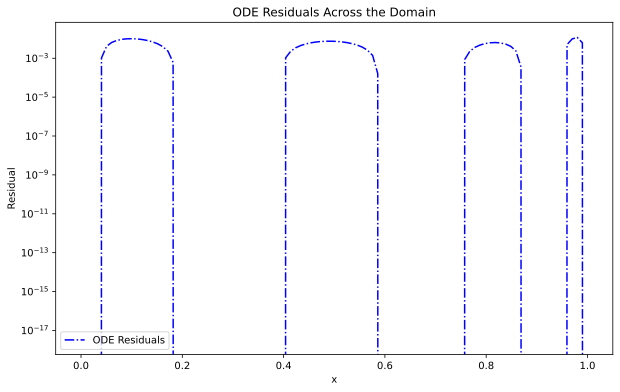

In [63]:
plot_ode_residuals(model, my_bvp, x_train)

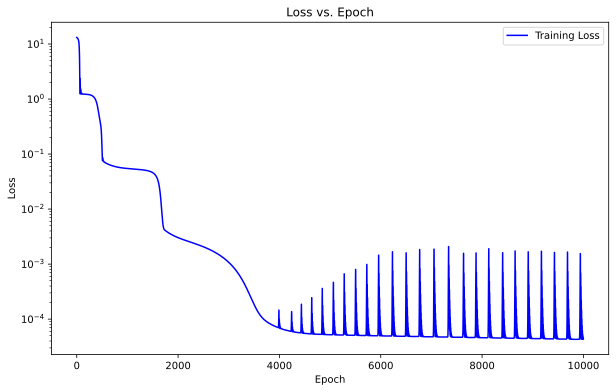

In [64]:
# Plot the loss vs. epoch
plot_loss_vs_epoch(loss_values)